**Necessary Imports**

In [1]:
###
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

from keras.applications import ResNet50
#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import VGG16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


**Drive Mount**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
save_path = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Resnet50/'
save_path1 = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Resnet50/'

In [5]:
#Run from here
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData.npy")
y_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData.npy")
y_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData.npy")
y_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


**Training Models**

# **Fine Tunning**

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

def R50(seed = None):
    np.random.seed(seed)
    base_model = ResNet50(weights="imagenet", include_top=False)
    for layer in base_model.layers[:86]:
        layer.trainable = False
    for layer in base_model.layers[86:]:
        layer.trainable = True
    x = (base_model.get_layer("conv4_block1_0_conv")).output
    mx = GlobalMaxPool2D()(x)
    x = BatchNormalization()(mx)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(5,activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=preds)
    return model

94765736/94765736 [==============================] - 1s 0us/step
0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv

In [7]:
modelFT_r50 = R50()

epochs = 50
opt = Adam(learning_rate=1e-3)
modelFT_r50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
modelFT_r50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [9]:
checkpointer = ModelCheckpoint(filepath='saved_models/resnet50_FT.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [10]:
print(y_train.shape)

(18123,)


In [11]:
import numpy as np
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)


In [44]:
trainResNetFT = modelFT_r50.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val,y_val_one_hot), epochs=50, callbacks=callbacks)

Epoch 1/50
566/567 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9749
Epoch 1: val_accuracy did not improve from 0.94907
567/567 [==============================] - 11s 20ms/step - loss: 0.0711 - accuracy: 0.9747 - val_loss: 0.1383 - val_accuracy: 0.9475 - lr: 1.0000e-05
Epoch 2/50
564/567 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9758
Epoch 2: val_accuracy did not improve from 0.94907
567/567 [==============================] - 11s 20ms/step - loss: 0.0674 - accuracy: 0.9758 - val_loss: 0.1388 - val_accuracy: 0.9460 - lr: 1.0000e-05
Epoch 3/50
565/567 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.9767
Epoch 3: val_accuracy did not improve from 0.94907
567/567 [==============================] - 11s 20ms/step - loss: 0.0669 - accuracy: 0.9767 - val_loss: 0.1383 - val_accuracy: 0.9460 - lr: 1.0000e-05
Epoch 4/50
565/567 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9765
Epoch 4: val_

Saving Model in GDrive

In [46]:
modelFT_r50.save(save_path + 'resnet50_FT.hdf5')
#model_vgg16.save_weights(save_path1 + "Weights_FineTunedVGG16.h5")


In [47]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = modelFT_r50.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 1s 20ms/step - loss: 0.1736 - accuracy: 0.9458


Evaluating Model

In [48]:
from tensorflow.keras.models import load_model
FT_ResNet50= load_model(save_path + 'resnet50_FT.hdf5')


26/26 [==============================] - 1s 17ms/step


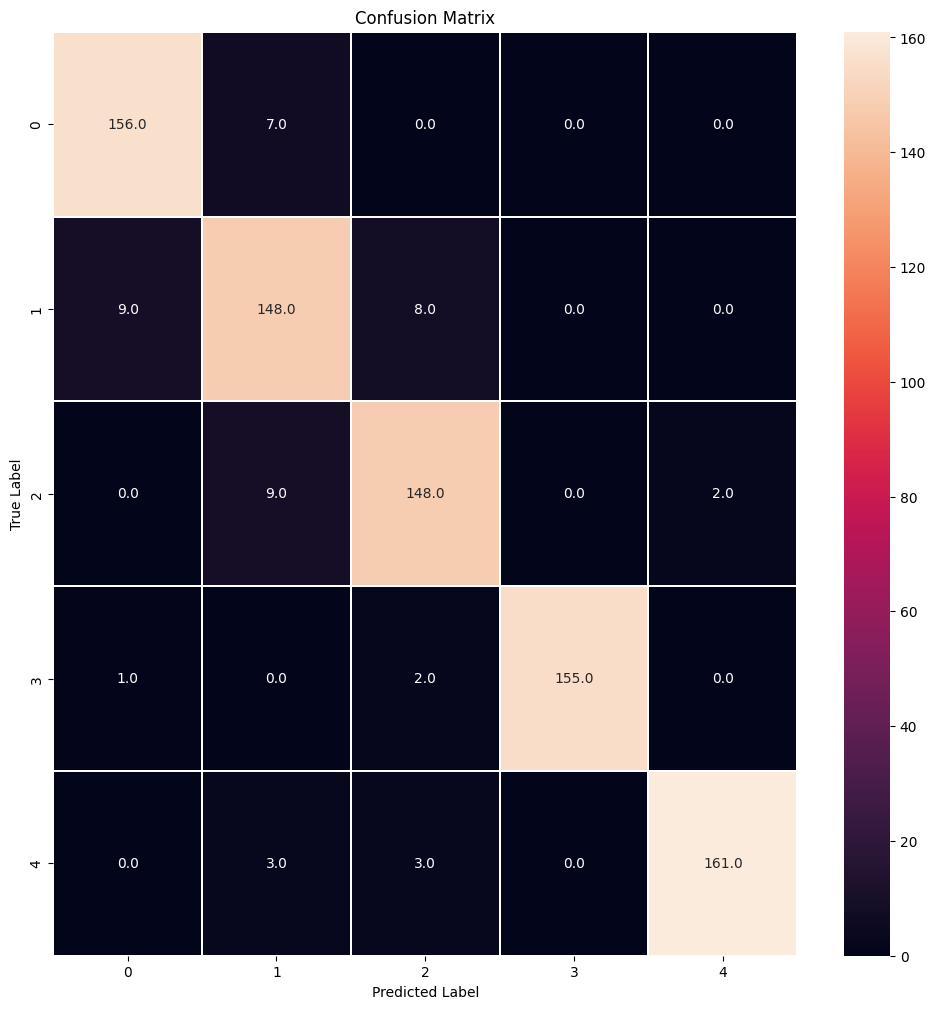

In [49]:
cancer_classes = np.unique(y_test)
pred = FT_ResNet50.predict(x_test)
y_pred = np.argmax(pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt='.1f', ax=ax, cmap="rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(cancer_classes)
ax.set_yticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [50]:
report1 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
0,0.939759,0.957055,0.948328,163.000000
1,0.886228,0.896970,0.891566,165.000000
2,0.919255,0.930818,0.925000,159.000000
3,1.000000,0.981013,0.990415,158.000000
4,0.987730,0.964072,0.975758,167.000000
accuracy,0.945813,0.945813,0.945813,0.945813
macro avg,0.946594,0.945985,0.946213,812.000000
weighted avg,0.946454,0.945813,0.946057,812.000000


# Cost Sensitive

In [51]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_test), class_weight.compute_class_weight('balanced', classes = np.unique(y_test),
                                        y = y_test))) 

class_weights

{0: 0.996319018404908,
 1: 0.9842424242424243,
 2: 1.0213836477987421,
 3: 1.0278481012658227,
 4: 0.9724550898203593}

In [52]:
modelCS_ResNet50=load_model(save_path + 'resnet50_FT.hdf5')
epochs = 50
opt = Adam(learning_rate=1e-3)
modelCS_ResNet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
checkpointer = ModelCheckpoint(filepath='saved_models/modelCS_ResNet50_CS.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[ reduce_lr, checkpointer]

In [61]:
modelCS_ResNet50.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=50, class_weight=class_weights,callbacks=callbacks)

Epoch 1/50
566/567 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9737
Epoch 1: val_accuracy improved from -inf to 0.94753, saving model to saved_models/modelCS_ResNet50_CS.hdf5
567/567 [==============================] - 12s 20ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.1934 - val_accuracy: 0.9475 - lr: 2.0000e-04
Epoch 2/50
565/567 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9780
Epoch 2: val_accuracy did not improve from 0.94753
567/567 [==============================] - 11s 20ms/step - loss: 0.0634 - accuracy: 0.9780 - val_loss: 0.1966 - val_accuracy: 0.9460 - lr: 2.0000e-04
Epoch 3/50
565/567 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9803
Epoch 3: val_accuracy did not improve from 0.94753
567/567 [==============================] - 11s 20ms/step - loss: 0.0546 - accuracy: 0.9804 - val_loss: 0.1942 - val_accuracy: 0.9460 - lr: 2.0000e-04
Epoch 4/50
565/567 [============================>.] -

In [62]:
modelCS_ResNet50.save(save_path + 'modelCS_ResNet50_CS.hdf5')
#modelCS_VGG16.save_weights(save_path1 + "Weights_FTCS_VGG16.h5")


In [63]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = modelCS_ResNet50.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 0s 17ms/step - loss: 0.2308 - accuracy: 0.9421


In [64]:
CS_ResNet50= load_model(save_path + 'modelCS_ResNet50_CS.hdf5')

26/26 [==============================] - 1s 17ms/step


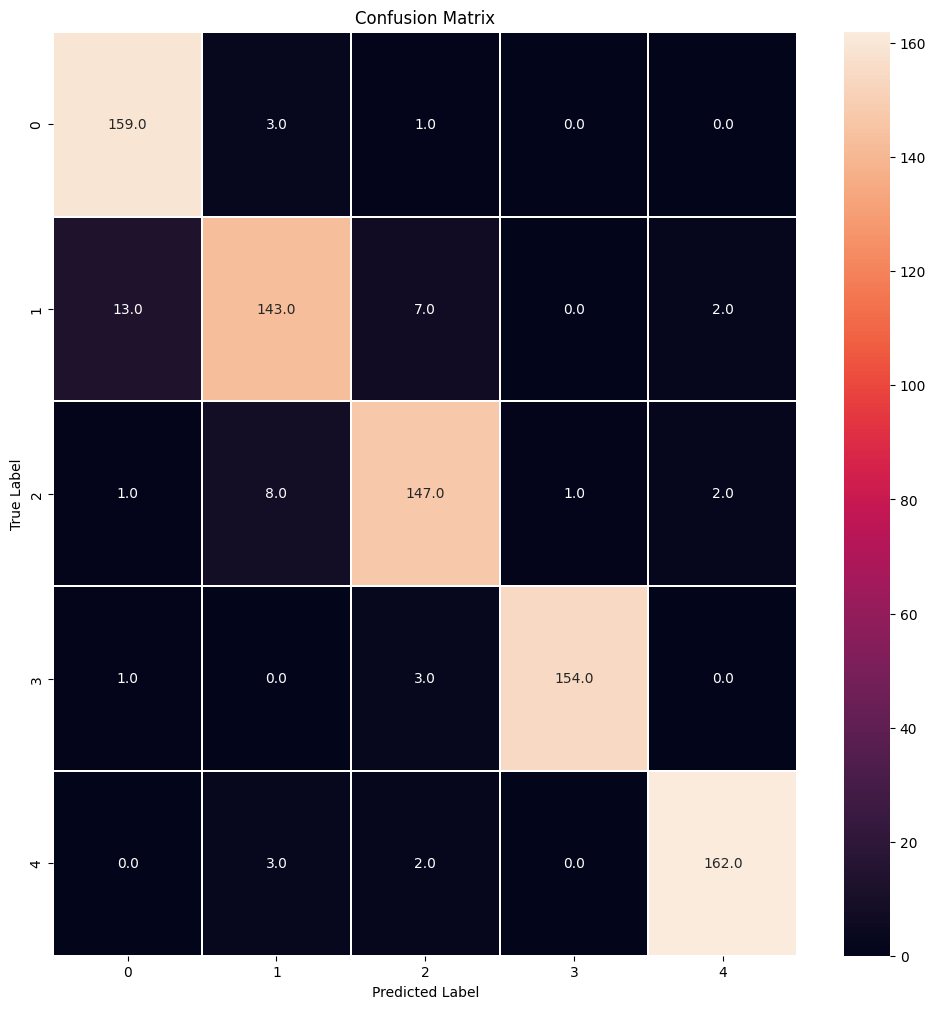

In [65]:
cancer_classes = np.unique(y_test)
pred = CS_ResNet50.predict(x_test)
y_pred = np.argmax(pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt='.1f', ax=ax, cmap="rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(cancer_classes)
ax.set_yticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()


In [66]:
report12 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report12).transpose()
df12

,precision,recall,f1-score,support
0,0.913793,0.975460,0.943620,163.000000
1,0.910828,0.866667,0.888199,165.000000
2,0.918750,0.924528,0.921630,159.000000
3,0.993548,0.974684,0.984026,158.000000
4,0.975904,0.970060,0.972973,167.000000
accuracy,0.942118,0.942118,0.942118,0.942118
macro avg,0.942565,0.942280,0.942090,812.000000
weighted avg,0.942454,0.942118,0.941951,812.000000
